In [803]:
topK = 10

In [804]:
T = 15

In [805]:
import numpy as np
import math
# import optimization as opt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os
import random
import pickle
import json
import time
import copy
from tqdm import tqdm

**Just checking if we are running on the right server**

In [806]:
!hostname

hcdmg2


In [807]:
num_users = 1801
num_items = 7428
num_features = 33

In [808]:
VERBOSITY = 0.05

def verbose(arg):
    if random.random() < VERBOSITY:
        print(arg)

verbose("echo")

In [809]:
def load_data(filename):
    train_interaction = np.load(filename + '_train_user_interaction.npy')
    train_review = np.load(filename + '_train_review.npy')
    val_interaction = np.load(filename + '_valid_user_interaction.npy')
    val_review = np.load(filename + '_valid_review.npy')
    test_interaction= np.load(filename + '_test_user_interaction.npy')
    test_review = np.load(filename + '_test_review.npy')
    
    return train_interaction, train_review, val_interaction, val_review, test_interaction, test_review

In [810]:
def loadSUV(i):
    SU = np.load('SU_{}.npy'.format(i))
    V = np.load('V_{}.npy'.format(i))
    return SU, V

def saveSUV(i):
    np.save('SU_{}'.format(i), SU)
    np.save('V_{}'.format(i), V)

In [811]:
!pwd

/u/ah3wj/CRS/FacT-CRS/unicorn


In [812]:
(train_user_interaction, train_review, val_user_interaction, val_reviews,
    test_user_interaction, test_review) = load_data("lastfm")

In [813]:
for i in range(len(train_review[0])):
    if(train_review[0][i] == 144 and train_review[1][i] == 3964):
        print(train_review[-1][i])

In [814]:
def visualize_hit(user_interaction, review):
    item_hit = np.full(num_items, 0)
    user_hit = np.full(num_users, 0)
    feature_hit = np.full(num_features, 0)

    for review_id in range(len(user_interaction)):
        u, i = user_interaction[review_id]
        item_hit[i] += 1
        user_hit[u] += 1

        single_review = review[review_id]
        idx = np.where(single_review == 1)
        feature_hit[idx] += 1
    print("ITEM")
    print(item_hit.mean(), item_hit.std())
    plt.plot(item_hit)
    plt.show()
    
    print("USER")
    print(user_hit.mean(), user_hit.std())
    plt.plot(user_hit)
    plt.show()
    
    print("FEATURES")
    plt.plot(feature_hit)
    plt.show()
    
    return user_hit, item_hit, feature_hit

ITEM
5.69345718901454 23.834623075219252


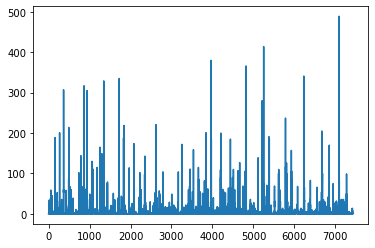

USER
23.481954469739033 4.3346712130693055


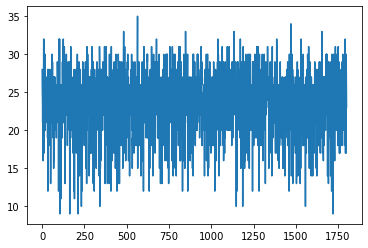

FEATURES


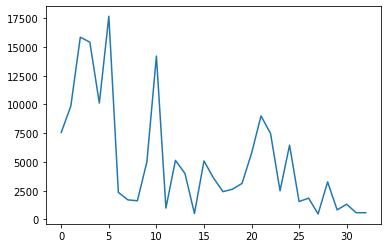

In [815]:
user_hit, item_hit, feature_hit = visualize_hit(user_interaction = train_user_interaction, review=train_review)

ITEM
0.7117662897145934 4.727523012349478


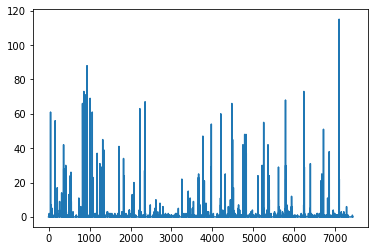

USER
2.935591338145475 1.7265166819305233


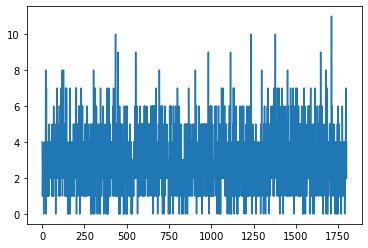

FEATURES


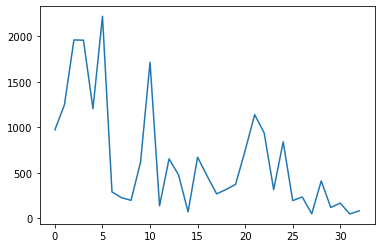

(array([4, 3, 1, ..., 2, 4, 2]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([ 972, 1246, 1958, 1955, 1204, 2218,  290,  227,  198,  614, 1714,
         139,  653,  477,   71,  671,  466,  269,  317,  374,  745, 1138,
         939,  315,  840,  195,  235,   51,  411,  120,  167,   49,   83]))

In [816]:
visualize_hit(user_interaction = test_user_interaction, review=test_review)

In [817]:
def item_opinion():
    op = np.zeros((num_items, num_features))
    for rid in range(len(train_user_interaction)):
        _, i = train_user_interaction[rid]
        features = train_review[rid]
        for f in range(len(features)):
            op[i, f] += features[f]
    return op

train_item_opinion = item_opinion()
train_item_opinion

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [818]:
# from sklearn.decomposition import NMF
# model = NMF(n_components=20, init='random', random_state=0)
# SU = model.fit_transform(train_review)
# H = model.components_
# SU.shape
# SU

In [819]:
# from sklearn.decomposition import NMF
# model = NMF(n_components=20, init='random', random_state=0, max_iter = 200)
# V = model.fit_transform(train_item_opinion)
# H = model.components_
# V.shape
# V

### Let's calculate sr@1 first

In [820]:
### Let's calculate MR@1 first
def MRR1(SU, V, user_interaction):
    mrr = 0
    success = 0
    count = 0
    for review_id in np.random.choice(len(user_interaction), size = 5000):
        count += 1
        u, i = user_interaction[review_id]
        pred = -SU[review_id].dot(V.T)
#         sur = SU[review_id]
#         pred = np.sum(np.abs((Vr-sur))**2,axis=-1)

        recommend = np.argsort(pred)
#         print("target:", i, "recommend:", recommend)
#         time.sleep(1)
        rank = np.where(recommend == i)[0][0]
        mrr += (rank+1)
        if(rank < topK):
            success += 1

        if((count) % 1000 == 0):
            print(mrr/(count), success/(count))

    print(mrr/(count), success/(count))


In [821]:
def MRR5(model, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        su = model.predict(reviews[review_id].reshape(1,-1))
        pred = -su.dot(V.T)[0]
        recommend = np.argsort(pred)
#         print("target:", i, "recommend:", recommend)
#         time.sleep(1)
        rank = np.where(recommend == i)[0][0]
    
        mrr += (rank+1)
        if(rank < topK):
            success += 1

        if((count) % 1000 == 0):
            print(mrr/(count), success/(count))

# Learn SU and V simultaneously

In [822]:
# saveSUV(i=0)
SU, V = loadSUV(i=0)

SU.shape

(42291, 20)

In [823]:
V.max()

3.3948151134791056

In [824]:
# V/=10

In [825]:
def get_rating_matrix():
    r = np.zeros((num_users, num_items))
    for u, i in train_user_interaction:
        r[u, i] = 1
    return r
rating_matrix = get_rating_matrix()
rating_matrix.sum()

42291.0

In [826]:
np.max(SU), np.max(V)

(3.2640658213148104, 3.3948151134791056)

In [827]:
# sr1(SU = SU, V=V, user_interaction = train_user_interaction)
MRR1(SU = SU, V=V, user_interaction = train_user_interaction)

40.616 0.538
38.9305 0.546
38.404333333333334 0.5486666666666666
38.2875 0.5485
39.0572 0.5446
39.0572 0.5446


In [828]:
SU[0].dot(V[3964]), SU[1].dot(V[3964]), SU[1].dot(V[5907])

(2.5592999706638464, 0.5066095951659657, 2.756568224831959)

In [829]:
# Learn SU and V simultaneously
lambda_BPR = 0.1

num_SGDUpdate = len(train_user_interaction)

alpha = 0.001
beta = 0.01


ALPHA = 0.01
BETA = 0.01

assert ALPHA >= alpha

def sigmoid(x):
    return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)), 
                    np.exp(x) / (1 + np.exp(x)))

def sgd_update_SUV_rating(SU, V, num_iter, num_BPRpairs):
    
    for _ in tqdm(range(num_iter)):
        for review_id in np.random.choice(len(train_user_interaction), size = num_SGDUpdate):
            u, i = train_user_interaction[review_id]
            pred = SU[review_id].dot(V[i].T)
            # Update user and item latent feature matrices
            sig = sigmoid(pred)
            e = 1-sig
        
            SU[review_id, :] +=  ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:]
            V[i, :] += ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:]

#             SU[review_id, :] +=  ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:]
#             V[i, :] += ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:]


            not_rated_items = np.where(rating_matrix[u, :] == 0)[0]
    
            for i in np.random.choice(not_rated_items, num_BPRpairs):
                pred = SU[review_id].dot(V[i].T)
                # Update user and item latent feature matrices
                sig = sigmoid(pred)
                e = 0-sig
                SU[review_id, :] +=  lambda_BPR*(ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:])
                V[i, :] += lambda_BPR*(ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:])
    
    return SU, V

In [831]:
SU, V = sgd_update_SUV_rating(SU, V, num_iter=10, num_BPRpairs = 5)

In [832]:
MRR1(SU = SU, V=V, user_interaction = train_user_interaction)

34.979 0.524
35.1845 0.5395
34.88466666666667 0.5453333333333333
36.29975 0.5415
37.562 0.5354
37.562 0.5354


In [434]:
# # Learn SU and V simultaneously
# num_SGDUpdate = len(train_user_interaction)

# alpha = 0.001
# beta = 0.01


# ALPHA = 0.01
# BETA = 0.01

# assert ALPHA >= alpha

# def bpr_update_SUV_rating(SU, V, num_BPRpairs):
#     count = 0
#     for _ in range(num_BPRpairs):
#         id1 = np.random.randint(len(train_user_interaction))
#         t1, a1 = train_user_interaction[id1]
#         a2 = np.random.randint(num_items)
        
#         if not np.any(np.all(np.isclose(train_user_interaction, np.array([t1, a2])), axis=1)):
#             count += 1
#             diff = np.dot(SU[t1], V[a1]) - np.dot(SU[t1], V[a2])
# #             print(diff.shape)
#             exponent = lambda_BPR *  (sigmoid(-diff) )
# # #             print((SU[t1] - SU[t2]).shape)
#             SU[t1] += exponent * ((V[a1] - V[a2]) + lambda_BPR * SU[t1])
#     print(count)

#     count = 0
#     for _ in range(num_BPRpairs):
#         id1 = np.random.randint(len(train_user_interaction))
#         t1, a1 = train_user_interaction[id1]
#         t2 = np.random.randint(len(train_user_interaction))
        
#         if not np.any(np.all(np.isclose(train_user_interaction, np.array([t2, a1])), axis=1)):
#             count += 1
#             diff = np.dot(SU[t1], V[a1]) - np.dot(SU[t2], V[a1])
# #             print(diff.shape)
#             exponent = lambda_BPR *  (sigmoid(-diff) )
# # #             print((SU[t1] - SU[t2]).shape)
#             V[a1] += exponent * ((SU[t1] - SU[t2]) + lambda_BPR * V[a1])
#     print(count)

    
#     return SU, V

In [792]:
# MRR5(model = review_tree, V = V, user_interaction=train_user_interaction, reviews=train_review)

# -----------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------
# Super User FacT

In [836]:
train_review.shape

(42291, 33)

In [837]:
class Node:
    def __init__(self, parent, vector, members, used_features):
        self.parent = parent
        self.vector = vector
        self.members = members        
        self.used_features = used_features
        
        self.feature = None
        self.pos_node = None
        self.neg_node = None
#         self.unknown_node = None
        
        self.error = np.inf
        

In [838]:
class Tree:
    def __init__(self, tree_type):
        assert tree_type in ["review", "item"]
        self.tree_type = tree_type
        if(self.tree_type == "review"):
            root_error, root_vector = fit(idx = np.array(range(len(train_user_interaction))), 
                                          training_type = tree_type,
                                          node_vector = np.mean(SU, axis=0), 
                                          SU = SU, V = V, num_iter=0, num_BPRpairs=0)
            self.root = Node(parent = None, vector = root_vector, members = np.array(range(len(train_user_interaction))), used_features = [])
            self.root.error = root_error

        elif(self.tree_type == "item"):
            root_error, root_vector = fit(idx = np.array(range(num_items)), 
                                          training_type = tree_type,
                                          node_vector = np.mean(V, axis=0), 
                                          SU = SU, V = V, num_iter=0, num_BPRpairs=0)
            self.root = Node(parent = None, vector = root_vector, members = np.array(range(num_items)), used_features = [])
            self.root.error = root_error
        else:
            raise ValueError("Invalid tree type")
        
        review_tree_condition = (tree_type == "review" and len(self.root.members) == len(train_user_interaction))
        item_tree_condition = (tree_type == "item" and len(self.root.members) == num_items)
        
        assert review_tree_condition or item_tree_condition        

In [839]:
def squared_error_and_mse(true, pred):
    '''I am assuming true and pred both to be 1-D array'''
    assert pred.ndim == 1
    error = ((true - pred)**2).sum()
    return error, error/len(pred)

In [840]:
def sgd_update_review_vector(single_vector, V, review_indices, num_iter, num_BPRpairs):
    
    error = 0
    for _ in range(num_iter):
        for review_id in (review_indices):
            u, i = train_user_interaction[review_id]
            pred = sigmoid(single_vector.dot(V[i].T))
            e = 1 - pred ## note single vector being used in prediction
            single_vector += ALPHA *  (e * V[i, :] -  BETA * single_vector)
            
            error += e
            
#             not_rated_items = np.where(rating_matrix[u, :] == 0)[0]
#             for i in np.random.choice(not_rated_items, num_BPRpairs):
#                 pred = SU[review_id].dot(V[i].T)
#                 # Update user and item latent feature matrices
#                 sig = sigmoid(pred)
#                 e = 0-sig
#                 single_vector += lambda_BPR * ALPHA *  (e * V[i, :] -  BETA * single_vector)
#                 error += e

                
    return single_vector, error

In [841]:
def sgd_update_item_vector(SU, single_vector, item_indices, review_idx, num_iter, num_BPRpairs):
    
    error = 0
    for _ in range(num_iter):
        for review_id in review_idx:
            u, i = train_user_interaction[review_id]
            pred = sigmoid(SU[review_id].dot(single_vector.T))
            e = 1 - pred ## note review_id being used in prediction
            
            error += e
            # Update user and item latent feature matrices
            single_vector += ALPHA * (e * SU[review_id] - BETA * single_vector)
            
#             not_rated_items = np.where(rating_matrix[u, :] == 0)[0]
#             for i in np.random.choice(not_rated_items, num_BPRpairs):
#                 pred = SU[review_id].dot(V[i].T)
#                 # Update user and item latent feature matrices
#                 sig = sigmoid(pred)
#                 e = 0-sig
#                 single_vector += lambda_BPR*ALPHA * (e * SU[review_id] - BETA * single_vector)
#                 error += e
                
    return single_vector, error

In [842]:
def fit(idx, training_type, node_vector, SU, V, num_iter, num_BPRpairs):
    '''
    I am assuming idx is an array of indices and NOT bool indices
    if training_type == review => we are updating SU, keeping V fixed
    if training_type == item => we are updating V, keeping SU fixed
    '''
    assert training_type in ["review", "item"]
    
    if (len(idx) == 0):
        return 0, None
    
    single_vector = copy.deepcopy(node_vector) ## we don't want to change node vector yet
    
    if training_type == "review":
        single_vector, error = sgd_update_review_vector(single_vector = single_vector, V = V, review_indices = idx, num_iter = num_iter, num_BPRpairs = num_BPRpairs)
        review_idx = idx
        
    elif training_type == "item":
        review_idx = np.array([i for i in range(len(train_user_interaction)) if train_user_interaction[i, 1] in idx ])
        single_vector, error = sgd_update_item_vector(SU = SU, single_vector = single_vector, item_indices = idx, review_idx = review_idx, num_iter = num_iter, num_BPRpairs = num_BPRpairs)
    return error, single_vector

In [843]:

SUmean = np.zeros_like(SU)
e, su = fit(idx = np.array(range(len(train_user_interaction))), 
                                          training_type = "review",
                                          node_vector = np.mean(SU, axis=0), 
                                          SU = SU, V = V, num_iter = 5, num_BPRpairs=1)
SUmean = SUmean + su
SUmean, e

(array([[0.18436846, 0.1523496 , 1.08871975, ..., 1.01337833, 0.57218199,
         0.4631941 ],
        [0.18436846, 0.1523496 , 1.08871975, ..., 1.01337833, 0.57218199,
         0.4631941 ],
        [0.18436846, 0.1523496 , 1.08871975, ..., 1.01337833, 0.57218199,
         0.4631941 ],
        ...,
        [0.18436846, 0.1523496 , 1.08871975, ..., 1.01337833, 0.57218199,
         0.4631941 ],
        [0.18436846, 0.1523496 , 1.08871975, ..., 1.01337833, 0.57218199,
         0.4631941 ],
        [0.18436846, 0.1523496 , 1.08871975, ..., 1.01337833, 0.57218199,
         0.4631941 ]]),
 49916.94592954997)

In [844]:
MRR1(SU = SUmean, V=V, user_interaction = train_user_interaction)

504.451 0.052
509.0555 0.038
530.997 0.037
518.91775 0.037
513.9148 0.0356
513.9148 0.0356


# -----------------------------------------------------------------------------------------

In [845]:
num_iter_review = 5
num_iter_item = 5

num_FIT = 10

# -----------------------------------------------------------------------------------------

In [846]:
N_TREE = 10
prob = 0.8

def sub_features():
    f = []
    for _ in range(N_TREE):
        l = []
        for i in range(num_features):
            if(random.random() < prob):
                l.append(i)
        
        f.append(l)
        
    return f


subflist = sub_features()
subflist

In [847]:
VERBOSE = 0.4

def find_best_split(node, training_type, flist):    
    '''
    I will assume node.members is non-empty
    if training_type == review => we are updating SU keeping V fixed
    if training_type == item => we are updating V keeping SU fixed
    '''
    if len(node.members) == 0:
        node = None
        return
    members = node.members
    
    assert training_type in ["review", "item"]
    if(training_type == "review"):
        opinion_matrix = train_review
    elif(training_type == "item"):
        opinion_matrix = train_item_opinion
        
    
    
    
    best_feature = None
    lowest_avg_error = np.inf
    lowest_pos_error = np.inf
    lowest_neg_error = np.inf

    best_pos_members = None
    best_neg_members = None
    
    best_pos_single_vector = None
    best_neg_single_vector = None
    
    
    for feature in flist:
        
        if (feature in node.used_features):
            continue
            
        pos_idx = []
        neg_idx = []
        
        for r in node.members:
            val = opinion_matrix[r, feature]
            if(val > 0):
                pos_idx.append(r)
            else:
                neg_idx.append(r)

        pos_idx = np.array(pos_idx)
        neg_idx = np.array(neg_idx)
        
        assert len(pos_idx) + len(neg_idx)  == len(node.members)
        
        pos_error, pos_single_vector  = fit(idx = pos_idx, training_type = training_type, node_vector = node.vector, SU = SU, V = V, num_iter = num_iter_review, num_BPRpairs=0)
        neg_error, neg_single_vector = fit(idx = neg_idx, training_type = training_type, node_vector = node.vector, SU = SU, V = V, num_iter = num_iter_review, num_BPRpairs=0)
        
#         pos_error = get_error(idx = pos_idx, training_type = training_type)
#         neg_error = get_error(idx = neg_idx, training_type = training_type)
        
        w_pos = 1 #len(pos_idx)/len(members)
        w_neg = 1 #len(neg_idx)/len(members)
        
        
        avg_error = w_pos*pos_error + w_neg*neg_error
        
        if (random.random() < VERBOSE):
            print("feature {} avg. error: {}, ratio: {}, pos:{}, neg: {}".format(feature,  avg_error, len(pos_idx)/len(members), len(pos_idx), len(neg_idx)))
        
        ## Update carefully:
        if(avg_error < lowest_avg_error):
            
            lowest_avg_error = avg_error
            best_feature = feature
            
            lowest_pos_error = pos_error
            lowest_neg_error = neg_error
            
            best_pos_members = pos_idx
            best_neg_members = neg_idx

    node.used_features.extend([best_feature])
    
    _, best_pos_single_vector  = fit(idx = best_pos_members, training_type = training_type, node_vector = node.vector, SU = SU, V = V, num_iter = num_FIT, num_BPRpairs=0)
    _, best_neg_single_vector = fit(idx = best_neg_members, training_type = training_type, node_vector = node.vector, SU = SU, V = V, num_iter = num_FIT, num_BPRpairs=0)
    
    return (lowest_avg_error, 
            lowest_pos_error,
            lowest_neg_error,
            best_feature, 
            best_pos_members,
            best_neg_members,
            best_pos_single_vector, 
            best_neg_single_vector)

In [848]:
review_tree = Tree(tree_type = "review")
review_tree.root.vector

array([0.99563082, 0.3461547 , 0.3768567 , 0.23527616, 0.10107501,
       0.20310607, 0.18003495, 0.08973604, 0.04457552, 0.18873565,
       0.16538261, 0.09369886, 0.05425107, 0.16745951, 0.13858143,
       0.04883872, 0.06861676, 0.30560493, 0.05577541, 0.11867393])

In [849]:
review_tree.root.members

array([    0,     1,     2, ..., 42288, 42289, 42290])

In [850]:
itmst = set(train_user_interaction[review_tree.root.members,1])
GINI = 1
if(len(review_tree.root.members) > 0):
    GINI -= (len(itmset)/len(review_tree.root.members))**2
    print(GINI)

0.9954649293096799


# -----------------------------------------------------------------------------------------

In [120]:
def create_tree(tree_type, node, depth, flist):
    if (depth > MAX_DEPTH):
        print("MAX DEPTH REACHED: {}".format(MAX_DEPTH))
        return
    
    if (node.feature is None):
        best = find_best_split(node = node, training_type = tree_type, flist = flist)
        if best is None:
            return
        
        
        ## early stopping GINI Index
        itmset = set(train_user_interaction[node.members,1])
        GINI = 1
        if(len(node.members) > 0):
            GINI -= (len(itmset)/len(node.members))**2
        if (GINI > 0.9967):
            return
            
        
        
        
        (lowest_avg_error, 
            lowest_pos_error,
            lowest_neg_error,
            best_feature, 
            best_pos_members,
            best_neg_members,
            best_pos_single_vector, 
            best_neg_single_vector) = best
        node.feature = best_feature
        node.error = lowest_avg_error
        
        node.pos_node = Node(parent = node, vector = best_pos_single_vector, members = best_pos_members, used_features = node.used_features.copy())
        node.neg_node = Node(parent = node, vector = best_neg_single_vector, members = best_neg_members, used_features = node.used_features.copy())

    else:
        print("CONTINUING BUILDING TREE FROM WHERE WE LEFT OFF.................")
    
    
    print("depth: {}, best feature id:{}, avg. error:{}".format(depth, node.feature, node.error))    

    print("# of pos members: ", len(node.pos_node.members))
    create_tree(tree_type = tree_type, node = node.pos_node, depth = depth +1, flist = flist)

    print('# of neg members: ',len(node.neg_node.members))
    create_tree(tree_type = tree_type, node = node.neg_node, depth = depth +1, flist = flist)


In [121]:
# forest = [ Tree(tree_type = "review") for _ in range(N_TREE)] ## don't overwrite the forest

In [123]:
MAX_DEPTH = 5
for i in range(N_TREE):
    review_tree = forest[i]
    create_tree(tree_type="review", node=review_tree.root, depth=0, flist = subflist[i])
    print("===============================")
    print("Finished building Tree", i)
    print("===============================")

CONTINUING BUILDING TREE FROM WHERE WE LEFT OFF.................
depth: 0, best feature id:10, avg. error:41434.6996726357
# of pos members:  14212
CONTINUING BUILDING TREE FROM WHERE WE LEFT OFF.................
depth: 1, best feature id:0, avg. error:5063.670871843155
# of pos members:  2611
CONTINUING BUILDING TREE FROM WHERE WE LEFT OFF.................
depth: 2, best feature id:22, avg. error:479.01508353083017
# of pos members:  1061
CONTINUING BUILDING TREE FROM WHERE WE LEFT OFF.................
depth: 3, best feature id:21, avg. error:137.92618736686867
# of pos members:  501
CONTINUING BUILDING TREE FROM WHERE WE LEFT OFF.................
depth: 4, best feature id:3, avg. error:51.92973208372382
# of pos members:  279
CONTINUING BUILDING TREE FROM WHERE WE LEFT OFF.................
depth: 5, best feature id:16, avg. error:24.46055124307445
# of pos members:  47
MAX DEPTH REACHED: 5
# of neg members:  232
MAX DEPTH REACHED: 5
# of neg members:  222
CONTINUING BUILDING TREE FRO

In [124]:
print("DONE!!!!!!!!!!!!!!!!!!")

DONE!!!!!!!!!!!!!!!!!!


In [346]:
# np.save('forest.npy', forest)
forest = np.load('forest.npy', allow_pickle = True)

In [347]:
sep = "----"
white ="    "

used_features = []

leaf_items = []
leaf_users = []


def print_tree(node, node_number, depth):
    if(node is None):
        return 0

    if(node.feature is None):
        num_users = {}
        num_items = {}
        for review_id in node.members:
            u, i = train_user_interaction[review_id]
            
            if u not in num_users:
                num_users[u] = 0
            if i not in num_items:
                num_items[i] = 0
            
            num_users[u] += 1
            num_items[i] += 1
        
        leaf_users.append(num_users)
        leaf_items.append(num_items)
        print("leaf node, #user:{}, #item:{} #members:{}".format(len(num_users), len(num_items), len(node.members)))

        return 1

#     print("feature: %d? error = %.1f #member: %d" %(node.feature, node.error, len(node.members)), "vector: ", node.vector is not None) 
    print("feature:", node.feature)
    used_features.append(node.feature)
    
    pos = neg = unknown = 0
    
    if(not node.pos_node is None):
        print( ("|    ")*(depth)+"|---- yes: ", end='')
        pos = print_tree(node.pos_node, node_number+1, depth+1)
        print( ("|    ")*(depth))
        
    if(not node.neg_node is None):
        print( ("|    ")*(depth)+"|---- no: ", end='')
        neg = print_tree(node.neg_node, node_number+pos+1, depth+1)
        print(("|"+white)*(depth))
    
    return pos+neg

print_tree(review_tree.root, 1, 0)


feature: 5
|---- yes: leaf node, #user:1777, #item:939 #members:17676

|---- no: feature: 10
|    |---- yes: feature: 1
|    |    |---- yes: feature: 3
|    |    |    |---- yes: feature: 22
|    |    |    |    |---- yes: feature: 9
|    |    |    |    |    |---- yes: leaf node, #user:162, #item:17 #members:169
|    |    |    |    |    
|    |    |    |    |    |---- no: leaf node, #user:136, #item:23 #members:138
|    |    |    |    |    
|    |    |    |    
|    |    |    |    |---- no: feature: 4
|    |    |    |    |    |---- yes: leaf node, #user:196, #item:30 #members:215
|    |    |    |    |    
|    |    |    |    |    |---- no: leaf node, #user:192, #item:47 #members:217
|    |    |    |    |    
|    |    |    |    
|    |    |    
|    |    |    |---- no: feature: 0
|    |    |    |    |---- yes: feature: 24
|    |    |    |    |    |---- yes: leaf node, #user:246, #item:30 #members:269
|    |    |    |    |    
|    |    |    |    |    |---- no: leaf node, #user:136, #item

33

In [59]:
leaf_items

[{1300: 7, 3963: 7},
 {4825: 14},
 {5250: 27},
 {1717: 4, 5250: 16, 6230: 2, 2081: 5, 5781: 2, 2089: 2, 1722: 3},
 {4204: 4, 868: 31},
 {1722: 14, 2081: 3, 1067: 5, 3258: 4, 1345: 2, 868: 6, 1717: 5, 2084: 2},
 {7098: 4, 5782: 7, 1839: 23, 4825: 7, 6389: 6, 1320: 4, 491: 3},
 {5250: 17,
  6230: 7,
  5782: 13,
  3963: 13,
  1722: 8,
  491: 2,
  739: 14,
  1300: 6,
  367: 6,
  1320: 8,
  5931: 20,
  3455: 17,
  3084: 5,
  6228: 21,
  5781: 6,
  1830: 7,
  4825: 5,
  159: 5,
  1717: 4,
  1080: 15,
  2084: 3,
  2353: 6,
  3006: 1,
  5786: 1},
 {5781: 4, 868: 13, 4204: 2},
 {868: 3, 4204: 4, 1717: 31, 2089: 7, 2482: 1, 2084: 1, 5781: 1},
 {5931: 1},
 {367: 11, 6227: 8, 6077: 1, 1320: 4, 3455: 7, 3006: 1, 491: 2, 7098: 1},
 {1839: 26},
 {3963: 8, 367: 1},
 {5785: 9, 4825: 23},
 {5931: 6,
  1070: 23,
  1345: 12,
  1839: 3,
  6077: 9,
  1830: 9,
  4825: 23,
  4515: 7,
  5816: 2,
  5785: 9,
  7094: 3,
  5783: 3,
  491: 1},
 {3963: 10},
 {159: 24, 160: 4, 6230: 23, 3963: 7, 6822: 4, 6228: 7, 235

In [187]:
def show_distribution(leaf_member):
    distribution=[]
    for d in leaf_member:
        distribution.append(len(d))
    plt.hist(distribution, bins=50, range=(0,100))
    plt.xlabel('# of unique items')
    plt.ylabel('Count')
    
    plt.savefig('hist-leaf-items', dpi = 400)
    
    print("mean:", np.mean(distribution), "std:", np.std(distribution))

# how many unique items/(users) per node?

mean: 45.4375 std: 109.90789823188322


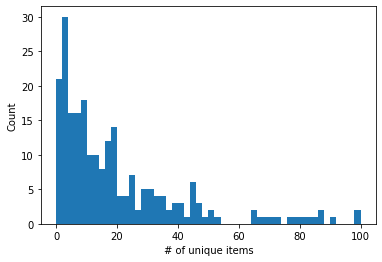

In [188]:
show_distribution(leaf_member = leaf_items)

mean: 128.42578125 std: 183.0284578052745


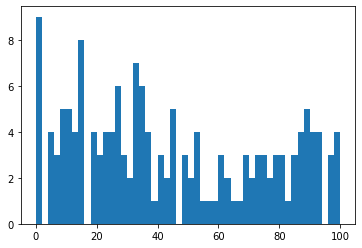

In [62]:
show_distribution(leaf_member = leaf_users)

# Same item in how many different leaf nodes?

mean:1.565967, std:4.104758


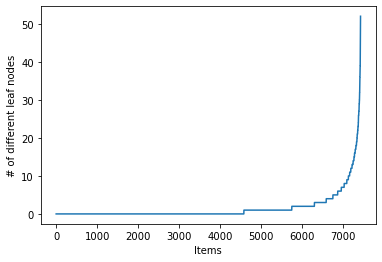

In [189]:
leaf_count_item = np.zeros(num_items)
for d in leaf_items:
    items = list(d.keys())
#     print(items)
    leaf_count_item[items] += 1
    
leaf_count_item = np.sort(leaf_count_item)
plt.plot(leaf_count_item)
plt.ylabel('# of different leaf nodes')
plt.xlabel('Items')
plt.savefig('leaf_count_item', dpi = 400)

print("mean:%f, std:%f"%(np.mean(leaf_count_item), np.std(leaf_count_item)))

# --------------------------------------------------------

In [151]:
class Model:
    def __init__(self, tree):
        self.tree = tree
        
    def predict(self,reviews, left):
        pred = []
        for r in reviews:
#             print(r)
            positive_attribute, node, n_left = ask_tree(node = self.tree.root, single_review = r, left = left)
    
            pred.append(node.vector)
        
        pred = np.array(pred)
        return pred, n_left

In [868]:
EARLY_STOPPING = 2300

def MRR10(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left
    
    
        val = single_review[node.feature]
        
        ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    
    total_turn = 0
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        
        already_rec = set()
        
        while(left > 0 and treecnt < N_TREE):
            review_tree = forest[next_tree]
            treecnt += 1
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            asked_tree.add(forest[next_tree])
            left-=1
            
            su = node.vector
            pred = -su.dot(V.T)
            sorted_list = np.argsort(pred)
#             print("target:", i, "recommend:", recommend)
#             time.sleep(1)
            kcount = 0
            recommend = []
            while(len(recommend) < topK):
                if not sorted_list[kcount] in already_rec:
                    recommend.append(sorted_list[kcount])
                    already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                kcount += 1
        
#             print(recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)
            if(i in recommend):
                success += 1
                turn_count = T - left
                break
            
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (forest[tree_idx] in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
            
        

        total_turn += turn_count
        if((count) % 1000 == 0):
#             print(mrr/(count*treecnt), success/(count))
            print(total_turn/count, success/count)
            
            
            

In [869]:
MRR10(forest = forest, V = V, user_interaction=test_user_interaction, reviews=test_review)

9.101 0.69
8.8825 0.7005
8.896666666666667 0.7006666666666667
8.858 0.704
8.8346 0.7062


In [877]:
def compare(reviews, interaction):
    
    leaf_success = 0
    pred_success = 0
    
    nk_success = {}
    nk_failed = {}
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left
    
    
        val = single_review[node.feature]
        
        ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left
    
    
    
    
    
    for r_id in range(len(reviews)):
        r = reviews[r_id]
        u, i = interaction[r_id]
        
        n_attribute = r.sum()
        identified_attribute, node, _ = ask(node = review_tree.root, single_review = r, left = 15)
        
        
        members = node.members
        vector = node.vector
            
        pred = -V.dot(vector)
        recommend = np.argsort(pred)[:topK]
        
        
        if(i in recommend):
            pred_success +=1
            nk_success[(n_attribute, identified_attribute)] = 1 + nk_success.get((n_attribute, identified_attribute), 0)
        else:
            nk_failed[(n_attribute, identified_attribute)] = 1 + nk_failed.get((n_attribute, identified_attribute), 0)
            
        
        all_candidates = np.unique(train_user_interaction[members,1])
        if(len(all_candidates) > topK):
            score = -V[all_candidates].dot(vector)
            idx = np.argpartition(score, topK)[:topK]
            all_candidates = all_candidates[idx]
        
        all_candidates = set(all_candidates)
        cand = 0
        while(len(all_candidates) < topK):
            all_candidates.add(recommend[cand])
            cand += 1
        
        
        if (i in all_candidates):
            leaf_success += 1
            successful_rid.append(r_id)
        else:
            rejected_items.append(i)
            rejected_reviews.append(r)
            
        global leaf_0_success, pred_0_success
        if (identified_attribute == 0 and i in all_candidates and i not in recommend[:cand]):
            leaf_0_success += 1
        elif (identified_attribute == 0 and i in recommend):
            pred_0_success +=  1
            
        
    print("leaf_success:", leaf_success/len(reviews)), print("pred_success:", pred_success/len(reviews))
#     print(np.mean(successN), np.std(successN))
#     plt.hist(successN, range=(0,2000))
    return nk_success, nk_failed

leaf_0_success = 0
pred_0_success = 0

rejected_items = []
rejected_reviews = []
successful_rid = []

nk_success,nk_failed = compare(reviews=test_review, interaction=test_user_interaction)

print(leaf_0_success, pred_0_success)

In [878]:

EARLY_STOPPING = 2300
ALPHA_NEG = 0
# rec_made_at = dict()
# rec_success_at = dict()




def factCRSwithoutNeg(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left+1
    
    
        val = single_review[node.feature]
        
        ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left   
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    
    total_turn = 0
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        
        already_rec = set()
        
        while(left > 0 and treecnt < N_TREE):
            review_tree = forest[next_tree]
            treecnt += 1
            
#             print("Now traversing: ", next_tree)
            
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            asked_tree.add(next_tree)
            left-= 1
#             print("traversed the tree...")
            
            su = copy.deepcopy(node.vector)
            leaf_candidates = np.unique(train_user_interaction[node.members,1])
#             print(leaf_candidates)
            score = -V[leaf_candidates].dot(su)
            idx = np.argsort(score)
            sorted_leaf_candidates = leaf_candidates[idx]

            recommend = []
            cand = 0
            while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
                if(not sorted_leaf_candidates[cand] in already_rec):
                    recommend.append(sorted_leaf_candidates[cand])
                    already_rec.add(sorted_leaf_candidates[cand])
                cand += 1
            
            ranked_recommend = []
            if(len(recommend) < topK):
                pred = -su.dot(V.T)
                sorted_list = np.argsort(pred)
    #             print("target:", i, "recommend:", recommend)
    #             time.sleep(1)
                kcount = 0
                while(len(recommend) < topK):
                    if not sorted_list[kcount] in already_rec:
                        recommend.append(sorted_list[kcount])
                        ranked_recommend.append(sorted_list[kcount])
                        already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                    kcount += 1
        
#             print(recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)
            if(i in recommend):
                success += 1
                turn_count = T - left
                break
            else:  ##Negative Feedback
                if ranked_recommend:
                    su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)
            
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (tree_idx in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
            
#             print("Checked all using history")

        total_turn += turn_count
        if((count) % 1000 == 0):
#             print(mrr/(count*treecnt), success/(count))
            print(total_turn/count, success/count)
    

In [852]:
factCRSwithoutNeg(forest = forest, V = V, user_interaction = test_user_interaction, reviews = test_review)

12.87 0.457
12.731 0.4835
12.681666666666667 0.488
12.6775 0.4885
12.6788 0.4914


In [880]:

EARLY_STOPPING = 2300



def factCRSoneTree(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left+1
    
    
        val = single_review[node.feature]
        
        ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left   
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    
    total_turn = 0
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        
        already_rec = set()
        
        while(left > 0 and treecnt <=1):
            review_tree = forest[next_tree]
            treecnt += 1
            
#             print("Now traversing: ", next_tree)
            
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            asked_tree.add(next_tree)
            left -= 1
            
#             print("traversed the tree...")
            
            su = copy.deepcopy(node.vector)
            leaf_candidates = np.unique(train_user_interaction[node.members,1])
#             print(leaf_candidates)
            score = -V[leaf_candidates].dot(su)
            idx = np.argsort(score)
            sorted_leaf_candidates = leaf_candidates[idx]

            recommend = []
            cand = 0
            while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
                if(not sorted_leaf_candidates[cand] in already_rec):
                    recommend.append(sorted_leaf_candidates[cand])
                    already_rec.add(sorted_leaf_candidates[cand])
                cand += 1
            
            ranked_recommend = []
            if(len(recommend) < topK):
                pred = -su.dot(V.T)
                sorted_list = np.argsort(pred)
    #             print("target:", i, "recommend:", recommend)
    #             time.sleep(1)
                kcount = 0
                while(len(recommend) < topK):
                    if not sorted_list[kcount] in already_rec:
                        recommend.append(sorted_list[kcount])
                        ranked_recommend.append(sorted_list[kcount])
                        already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                    kcount += 1
        
#             print(recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)
            if(i in recommend):
                success += 1
                turn_count = T - left
                break
            else:  ##Negative Feedback
                if ranked_recommend:
                    su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)
            
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (tree_idx in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
            
#             print("Checked all using history")

        total_turn += turn_count
        if((count) % 1000 == 0):
#             print(mrr/(count*treecnt), success/(count))
            print(total_turn/count, success/count)
    
factCRSoneTree(forest = forest, V = V, user_interaction = test_user_interaction, reviews = test_review)

10.384 0.378
10.2245 0.3895
10.247333333333334 0.388
10.25975 0.387
10.2738 0.386


In [368]:

EARLY_STOPPING = 2300
ALPHA_NEG = 1e-1




rec_made_at = dict()
ques_asked_at = dict()
rec_success_at = dict()




def factCRS(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left+1
    
    
        val = single_review[node.feature]
        
        ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left   
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    
    total_turn = 0
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        
        already_rec = set()
        
        while(left > 0 and treecnt < N_TREE):
            review_tree = forest[next_tree]
            treecnt += 1
            
#             print("Now traversing: ", next_tree)
            
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            asked_tree.add(next_tree)
            
#             print("traversed the tree...")
            
            su = copy.deepcopy(node.vector)
            leaf_candidates = np.unique(train_user_interaction[node.members,1])
#             print(leaf_candidates)
            score = -V[leaf_candidates].dot(su)
            idx = np.argsort(score)
            sorted_leaf_candidates = leaf_candidates[idx]

            recommend = []
            cand = 0
            while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
                if(not sorted_leaf_candidates[cand] in already_rec):
                    recommend.append(sorted_leaf_candidates[cand])
                    already_rec.add(sorted_leaf_candidates[cand])
                cand += 1
            
            ranked_recommend = []
            if(len(recommend) < topK):
                pred = -su.dot(V.T)
                sorted_list = np.argsort(pred)
    #             print("target:", i, "recommend:", recommend)
    #             time.sleep(1)
                kcount = 0
                while(len(recommend) < topK):
                    if not sorted_list[kcount] in already_rec:
                        recommend.append(sorted_list[kcount])
                        ranked_recommend.append(sorted_list[kcount])
                        already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                    kcount += 1
        
#             print(recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)

            rec_made_at[T-left] = 1 + rec_made_at.get(T-left, 0)


            if(i in recommend):
                rec_success_at[T-left] = 1 + rec_success_at.get(T-left, 0)
                success += 1
                turn_count = T - left
                break
            else:  ##Negative Feedback
                if ranked_recommend:
                    su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)
            
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (tree_idx in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
            
#             print("Checked all using history")

        total_turn += turn_count
        if((count) % 300 == 0):
#             print(mrr/(count*treecnt), success/(count))
            print(total_turn/count, success/count)
    
factCRS(forest = forest, V = V, user_interaction = test_user_interaction, reviews = test_review)

10.2 0.55
9.953333333333333 0.575
10.07 0.5633333333333334
10.0775 0.5608333333333333
10.057333333333334 0.5626666666666666
10.056111111111111 0.56
9.98047619047619 0.5676190476190476
9.992083333333333 0.5666666666666667
9.971851851851852 0.5681481481481482
9.995 0.565
9.976666666666667 0.5675757575757576
9.992222222222223 0.5666666666666667
9.985128205128206 0.5674358974358974
10.005952380952381 0.565
10.004222222222221 0.5653333333333334
10.024375 0.5633333333333334
10.028039215686274 0.5641176470588235
10.02574074074074 0.565
10.017894736842106 0.5664912280701755
10.024333333333333 0.5658333333333333
10.005873015873016 0.5671428571428572
9.977424242424242 0.5703030303030303
9.988840579710144 0.5691304347826087
9.970972222222223 0.5705555555555556
9.968133333333334 0.5706666666666667
9.963205128205129 0.571025641025641
9.95679012345679 0.571358024691358
9.959285714285715 0.5708333333333333
9.958735632183908 0.5708045977011494
9.952666666666667 0.5716666666666667
9.940752688172044 0.5

In [419]:

EARLY_STOPPING = 20
ALPHA_NEG = 1e-1




rec_made_at = dict()
ques_asked_at = dict()
rec_success_at = dict()




def varytopKCRS(forest, V, user_interaction, reviews):
    
    topK = 50
    
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left+1
    
    
        val = single_review[node.feature]
        
        ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    
    total_turn = 0
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        
        already_rec = set()
        
        while(left > 0 and treecnt < N_TREE):
            review_tree = forest[next_tree]
            treecnt += 1
            
#             print("Now traversing: ", next_tree)
            
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            asked_tree.add(next_tree)
            left -= 1
#             print("traversed the tree...")
            
            su = copy.deepcopy(node.vector)
            leaf_candidates = np.unique(train_user_interaction[node.members,1])
#             print(leaf_candidates)
            score = -V[leaf_candidates].dot(su)
            idx = np.argsort(score)
            sorted_leaf_candidates = leaf_candidates[idx]

            recommend = []
            cand = 0
            while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
                if(not sorted_leaf_candidates[cand] in already_rec):
                    recommend.append(sorted_leaf_candidates[cand])
                    already_rec.add(sorted_leaf_candidates[cand])
                cand += 1
            
            ranked_recommend = []
            if(len(recommend) < topK):
                pred = -su.dot(V.T)
                sorted_list = np.argsort(pred)
    #             print("target:", i, "recommend:", recommend)
    #             time.sleep(1)
                kcount = 0
                while(len(recommend) < topK):
                    if not sorted_list[kcount] in already_rec:
                        recommend.append(sorted_list[kcount])
                        ranked_recommend.append(sorted_list[kcount])
                        already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                    kcount += 1
        
#             print(recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)

            rec_made_at[T-left] = 1 + rec_made_at.get(T-left, 0)


            if(i in recommend):
                rec_success_at[T-left] = 1 + rec_success_at.get(T-left, 0)
                success += 1
                turn_count = T - left
                break
            else:  ##Negative Feedback
                if ranked_recommend:
                    su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)

#                 su += ALPHA_NEG* np.mean(V[idx[40:50]], axis = 0)
                    
            
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (tree_idx in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
            
#             print("Checked all using history")

        total_turn += turn_count
    

    print(total_turn/count, success/count)
    
varytopKCRS(forest = forest, V = V,user_interaction = test_user_interaction[:firstr], reviews = test_review[:firstr])

6.843333333333334 0.89


In [867]:

ALPHA_NEG = 1e-1
EARLY_STOPPING = 2300




rec_made_at = dict()
ques_asked_at = dict()
rec_success_at = dict()




def diffnegfactCRS(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    topK = 10
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
#         if(node.feature not in qa):
#             print("Q: {} > 0?:".format(node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left
    
    
        val = single_review[node.feature]
        
        ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left    
    
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    
    total_turn = 0
    
    su_list = []
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        succ_turn = False
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        
        already_rec = []
        
        while(left > 0 and treecnt < N_TREE):
            review_tree = forest[next_tree]
            treecnt += 1
            
#             print("Now traversing: ", next_tree)
            
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            
            left -= 1
            
            asked_tree.add(next_tree)
            
#             print("traversed the tree...")
            
            su = copy.deepcopy(node.vector)
#             su_list.append(su)
#             su = np.mean(su_list, axis = 0)
            
            
            leaf_candidates = np.unique(train_user_interaction[node.members,1])
#             print(leaf_candidates)
            score = -V[leaf_candidates].dot(su)
            idx = np.argsort(score)
            sorted_leaf_candidates = leaf_candidates[idx]

            recommend = []
            cand = 0
            while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
                if(not sorted_leaf_candidates[cand] in already_rec):
                    recommend.append(sorted_leaf_candidates[cand])
                    already_rec.append(sorted_leaf_candidates[cand])
                cand += 1
            
            ranked_recommend = []
            if(len(recommend) < topK):
                pred = -su.dot(V.T)
                sorted_list = np.argsort(pred)
    #             print("target:", i, "recommend:", recommend)
    #             time.sleep(1)
                kcount = 0
                while(len(recommend) < topK):
                    if not sorted_list[kcount] in already_rec:
                        recommend.append(sorted_list[kcount])
                        ranked_recommend.append(sorted_list[kcount])
                        already_rec.append(sorted_list[kcount])  # we don't want to recommend the same item twice
                    kcount += 1
        
#             print(recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)

            rec_made_at[T-left] = 1 + rec_made_at.get(T-left, 0)


#             print(recommend)
            if(i in recommend):
                succ_turn = True
#                 print("accept")
                rec_success_at[T-left] = 1 + rec_success_at.get(T-left, 0)
                success += 1
                turn_count = T - left
                break
            else:  ##Negative Feedback
                if ranked_recommend:
                    su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)

                su += ALPHA_NEG* np.mean(V[idx[40:50]], axis = 0) # move toward the later items
                    
            
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (tree_idx in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
            
#             print("Checked all using history")


        if(count % 100 == 0):
            print(total_turn/count, success/count)
        
        total_turn += turn_count

        
T = 15
        
diffnegfactCRS(forest = forest, V = V,user_interaction = val_user_interaction, reviews = val_reviews)
print("DONE!")

8.81 0.69
8.46 0.725
8.536666666666667 0.7066666666666667
8.67 0.7025
8.734 0.706
8.705 0.7133333333333334
8.744285714285715 0.7128571428571429
8.65875 0.715
8.61888888888889 0.7222222222222222
8.703 0.718
8.657272727272728 0.7236363636363636
8.646666666666667 0.7225
8.655384615384616 0.72
8.622142857142856 0.725
8.64 0.726
8.6525 0.72625
8.634705882352941 0.7276470588235294
8.705555555555556 0.7244444444444444
8.716315789473684 0.7231578947368421
8.7335 0.721
8.733333333333333 0.72
8.729090909090909 0.7236363636363636
8.740869565217391 0.7217391304347827
8.72375 0.72375
8.726 0.7216
8.705769230769231 0.7238461538461538
8.702592592592593 0.7225925925925926
8.736071428571428 0.7196428571428571
8.728275862068966 0.7196551724137931
8.728333333333333 0.7196666666666667
8.72516129032258 0.7193548387096774
8.7290625 0.71875
8.731515151515152 0.7181818181818181
8.705 0.7197058823529412
8.716285714285714 0.718
8.7325 0.7166666666666667
8.739189189189188 0.715945945945946
8.736842105263158 0.71

In [870]:
rec_probability = np.zeros(T+1)
for turn in range(1,T+1):
    if((rec_made_at.get(turn, 0) + ques_asked_at.get(turn, 0)) > 0):
        rec_probability[turn]  = rec_made_at.get(turn, 0)/(rec_made_at.get(turn, 0) + ques_asked_at.get(turn, 0))
        print("rec_probability at turn", turn, ":", rec_probability[turn])

rec_probability at turn 1 : 0.0
rec_probability at turn 2 : 0.16689150125264984
rec_probability at turn 3 : 0.18067226890756302
rec_probability at turn 4 : 0.3269901440485216
rec_probability at turn 5 : 0.1287720346579026
rec_probability at turn 6 : 0.2749960511767493
rec_probability at turn 7 : 0.27523675196453756
rec_probability at turn 8 : 0.27848101265822783
rec_probability at turn 9 : 0.2122951967511553
rec_probability at turn 10 : 0.28205128205128205
rec_probability at turn 11 : 0.19702311006658832
rec_probability at turn 12 : 0.24828224101479915
rec_probability at turn 13 : 0.25488225157955197
rec_probability at turn 14 : 1.0
rec_probability at turn 15 : 1.0


In [871]:
rec_success_probability = np.zeros(T+1)
for turn in range(1,T+1):
    if((rec_made_at.get(turn, 0)) > 0):
        rec_success_probability[turn] = rec_success_at.get(turn,0)/rec_made_at.get(turn, 0)
        print("rec_success at turn", turn, ":", rec_success_probability[turn])

rec_success at turn 2 : 0.18937644341801385
rec_success at turn 3 : 0.20930232558139536
rec_success at turn 4 : 0.20612102944586136
rec_success at turn 5 : 0.2552204176334107
rec_success at turn 6 : 0.252441125789776
rec_success at turn 7 : 0.16251830161054173
rec_success at turn 8 : 0.22396694214876034
rec_success at turn 9 : 0.03496042216358839
rec_success at turn 10 : 0.04931669637551991
rec_success at turn 11 : 0.055666003976143144
rec_success at turn 12 : 0.05534858967535923
rec_success at turn 13 : 0.03774647887323944
rec_success at turn 14 : 0.04648241206030151
rec_success at turn 15 : 0.07609668755595345


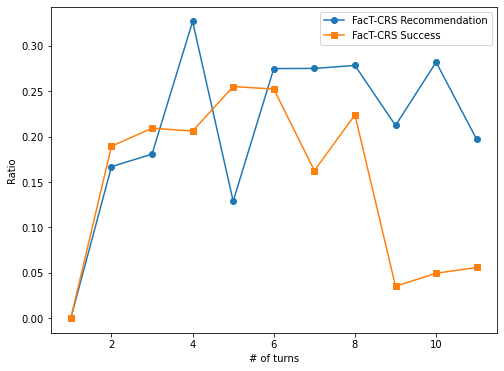

In [872]:
length = range(1,12)

plt.figure(figsize = (8,6))


plt.plot(length,rec_probability[1:12], label='FacT-CRS Recommendation', marker = 'o')
plt.plot(length,rec_success_probability[1:12], label='FacT-CRS Success', marker = 's')

plt.xlabel('# of turns')
plt.ylabel('Ratio')
plt.legend()
plt.savefig('rec-succ.png',dpi = 400)

In [577]:
rec_made_at

{7: 540,
 11: 717,
 13: 496,
 14: 502,
 15: 544,
 3: 140,
 8: 313,
 12: 522,
 2: 326,
 4: 387,
 5: 335,
 6: 268,
 9: 369,
 10: 411}

In [545]:
rec_success_at

{7: 304,
 12: 26,
 11: 49,
 5: 80,
 8: 7,
 13: 38,
 10: 14,
 15: 33,
 6: 59,
 9: 20,
 4: 15,
 14: 21,
 3: 20}

In [391]:
rec_probability[1:12], rec_success_probability[1:12]

(array([0.02219551, 0.16971987, 0.13979142, 0.15363703, 0.2967879 ,
        0.16022443, 0.17596562, 0.11713683, 0.10728745, 0.06653226,
        0.17857143]),
 array([0.01666667, 0.03947921, 0.04017217, 0.05567544, 0.12658305,
        0.06841155, 0.09200445, 0.10646012, 0.09602929, 0.15151515,
        0.4       ]))

In [ ]:
for n in range(1, 16):
    for k in range(0, n+1):
        nk_s = nk_success.get((n,k), 0)
        nk_f = nk_failed.get((n,k), 0)
        
        if((nk_s + nk_f) == 0):
            res = "null"
        else:
            res = nk_s /(nk_s + nk_f)

        print(res, end=" ")
    print()

In [200]:
def count_attributes(reviews):
    reviews = np.array(reviews)
    print(reviews.sum(axis = 1).mean(), reviews.sum(axis = 1).std())
    
count_attributes(reviews = rejected_reviews)
count_attributes(reviews = train_review)
count_attributes(reviews = train_review[successful_rid])

2.1542912246865957 1.5136728406054296
4.034853751389185 2.4605978460446605
4.02036987402841 2.474173859643712


In [202]:
def greaterThanFailed(k):
    count_all = 0
    count_rej = 0
    for r in train_review:
        if(r.sum() >= k):
            count_all += 1
    for r in rejected_reviews:
        if(r.sum() >= k):
            count_rej += 1
    return count_all, count_rej
    
greaterThanFailed(4)

(21741, 449)

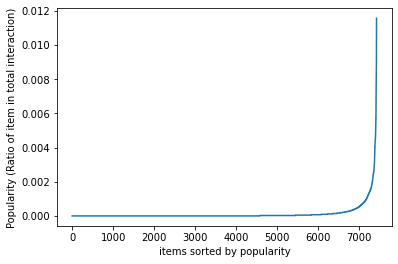

In [197]:
## item hit
rejected_uniq_items = np.unique(rejected_items)
# print(item_hit[rejected_uniq_items]).mean(), item_hit[rejected_uniq_items].std())
plt.plot(sorted(item_hit/len(train_review)))

plt.ylabel('Popularity (Ratio of item in total interaction)')
plt.xlabel('items sorted by popularity')
# plt.plot(sorted(item_hit[rejected_items]/len(train_review)))
# plt.show()
plt.savefig('popularity-all.png', dpi = 400)

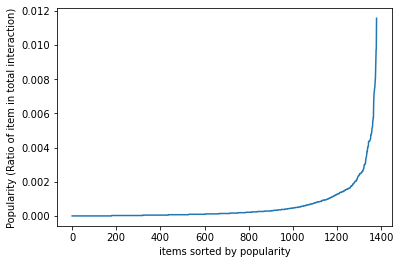

In [196]:
plt.plot(sorted(item_hit[rejected_uniq_items]/len(train_review)))
plt.ylabel('Popularity (Ratio of item in total interaction)')
plt.xlabel('items sorted by popularity')
plt.savefig('popularity-failed.png', dpi = 400)

In [118]:
print((sum(item_hit/len(train_review) > 0.001)) / len(item_hit))

print((sum(item_hit[rejected_uniq_items]/len(train_review) > 0.001)) / len(rejected_uniq_items))


0.03257942918686053
0.15797101449275364


# False positive and negative

In [ ]:
def count_fp_fn(node, single_review, depth, target):

    fp = False
    fn = False
    
    if(node.feature is None):
#         print("leaf node")
        return node.members, depth, node.vector, fp, fn
#     print("Q{}: {} > 0?:".format(depth+1, node.feature))   

    val = single_review[node.feature]

    if(val > 0):
#         print("yes")
        
        if(train_item_opinion[target, node.feature] <= 0 ):
            fp = True
            
        if(not node.pos_node is None):
            m,d,v,a,b= count_fp_fn(node.pos_node, single_review, depth+1, target)
            return m, d, v, (a or fp), (b or fn)
        else:
            return node.members, depth+1, node.vector, fp, fn
        
    else:
#         print("no")
        if(train_item_opinion[target, node.feature] > 0 ):
            fn = True
            
        if(not node.neg_node is None):
            m,d,v,a,b= count_fp_fn(node.pos_node, single_review, depth+1, target)
            return m, d, v, (a or fp), (b or fn)
        else:
            return node.members, depth+1, node.vector, fp, fn
        

In [ ]:

def total_fp_fn(reviews, interaction):
    
    success_fp = 0
    success_fn = 0

    failure_fp = 0
    failure_fn = 0

    success = 0
    
#     for r_id in range(len(reviews)):
    for r_id in range(4800):
        r = reviews[r_id]
        u, i = interaction[r_id]

        members, _, vector, fp, fn = count_fp_fn(node = review_tree.root, single_review = r, depth = 0, target = i)
        
        su = review_model.predict(r.reshape(1,-1))#??????????????????????
        pred = -su.dot(V.T)[0]
#         recommend = np.argsort(pred)
        
#         pred = -vector.dot(V.T)
        recommend = np.argpartition(pred, topK)[:topK]
        if(i in recommend): #success
            success += 1
            if(fp):
                success_fp += 1
            if(fn):
                success_fn += 1
        else: #failure
            if(fp):
                failure_fp += 1
            if(fn):
                failure_fn += 1
                
        if((r_id+1)%1000 == 0):
            print(success/(r_id+1))
    
    print(success, success_fp, success_fn, failure_fp, failure_fn)
                
total_fp_fn(reviews=test_review, interaction=test_user_interaction)

# --------------------- Personalization -------------------------------------------

In [ ]:
def personalize(model, num_iter):
    V_copy = copy.deepcopy(V)
    
    SU_predict = model.predict(train_review)
    SU_predict= sgd_update_SU(SU = SU_predict, V = V_copy, num_iter = num_iter)

#     SU_predict, V_copy = sgd_update_SUV_rating(SU = SU_predict, V = V_copy, num_iter = num_iter)
    
#     bpr_update_SUV_rating(SU = SU_predict, V = V_copy, num_BPRpairs = 10000)
    
    return SU_predict, V_copy

In [ ]:
def sgd_update_SU(SU, V, num_iter):
    from tqdm import tqdm
    for _ in tqdm(range(num_iter)):
        for review_id in np.random.choice(len(train_user_interaction), size = num_SGDUpdate):
            u, i = train_user_interaction[review_id]
            pred = SU[review_id].dot(V[i].T)
            e = 1-sigmoid(pred) ## note review_id being used in prediction
            # Update user and item latent feature matrices
            SU[review_id, :] +=  ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:]
#             V[i, :] += ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:]
    
    return  SU

In [ ]:
def sgd_update_V(SU, V, num_iter):
    from tqdm import tqdm
    for _ in tqdm(range(num_iter)):
        for review_id in np.random.choice(len(train_user_interaction), size = num_SGDUpdate):
            u, i = train_user_interaction[review_id]
            pred = SU[review_id].dot(V[i].T)
            e = 1 - sigmoid(pred) ## note review_id being used in prediction
            # Update user and item latent feature matrices
#             SU[review_id, :] +=  ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:]
            V[i, :] += ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:]
    
    return  V

In [ ]:
SU_new, V_copy = personalize(model = review_model, num_iter = 100)

In [ ]:
# SU, V = loadSUV()
# MRR1(SU = SU_new, V=V, user_interaction = train_user_interaction)
print("-----------------------")
MRR1(SU = SU_new, V=V_copy, user_interaction = train_user_interaction)


In [ ]:
i = 500
V[i], V_copy[i]

In [ ]:
j = 500
SU[j], SU_new[j]

In [ ]:
saveSUV(i=1)

In [ ]:
def save_tree(i):
    with open("review_tree_{}.pkl".format(i), "wb") as f:
        pickle.dump(review_tree, f)
        
def load_tree(i):
    with open("review_tree_{}.pkl".format(i), "rb") as f:
        pickle.dump(review_tree, f)

In [ ]:
save_tree(i = 1)

In [ ]:
saveSUV(i=1)

In [ ]:
SU, _ = loadSUV(i = 1)

# ----------------------------------------------------------------

# ----------------------------------------------------------------

In [ ]:
import os.path
import time

MAX_ITER = 50
SGD_ITER = 1500

for i in range(0,MAX_ITER+1):
    
    fpath = "V_{}.npy".format(i)
    while not os.path.exists(fpath):
        print("waiting for ", fpath)
        time.sleep(60)
    if os.path.isfile(fpath):
        V = np.load('V_{}.npy'.format(i))
    else:
        raise ValueError("%s isn't a file!" % fpath)
        
    create_tree(tree_type="item", node=item_tree.root, depth=0)
    print_tree(item_tree.root, 0, 0)
    
    review_model = Model(tree = item_tree)
    SU_new, V_copy = personalize(model = item_model, num_iter = SGD_ITER)
    
    print("RESULT OF ITERATION...")
    MRR1(SU = SU_new, V=V_copy, user_interaction = train_user_interaction)
    
    SU = SU_new
    np.save('SU_{}'.format(i), SU)
    save_tree(i = i)
    review_tree = Tree(tree_type = "review")


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [161]:
s = "this is a, string"
tokens = s.split(",")
for t in tokens:
    print(t)

this is a
 string


In [177]:
import re
re.split('\.\+', "This.is.working+maybe")

['This.is.working+maybe']

In [179]:
s = "this is a"

news = ""

for c in s:
    news = c+news

news

'a si siht'